# Information and values needed:

| Info | Summer22 NaI (run 376, ch 1) | Spring23 NaI (run 599, ch 1) |
|----------|----------|----------|
| Path RDT files | (mppui4) /ptmp/mpp/projects/cosinus/cryodata/cryo/fridge3/run376 | (mppui4) /p/MPP/COSINUS/cryodata/cryo/fridge2/run599 |
| Path HDF files | (mppui4) /ptmp/mpp/fwagner/cosinus_run376_testcryo/ | (mppui4) /ptmp/mpp/fwagner/cosinus_run599/ |
| File names | test_Co57_from_left_angle_{001..5}, test_bck_{007..12}, test_ncal_{001..5}, bck_012 after ncal | test_ch1_ch2_ch4_Co57_00{1..2}, test_ch1_ch2_ch4_ncal_00{1..3} , test_ch1_ch2_ch4_bck_00{1..3} |
| Bath temperature | 15 mK (est) | 11.65 kOhm (table below) |
| Shunt resistance | 40 mOhm (est) | 40 mOhm |
| Coil inductivity | 1.3 muH (est) | 1.3 muH |
| Sample frequency | 50000 | 200000 |
| Record length | 32768 | 32768 |
| Path SEV particle | ./remo_tes_data/ | ./remo_tes_data/ |
| Path SEV testpulse | ./remo_tes_data/ | ./remo_tes_data/ |
| Rise and Decay time TPs | -r 0.5ms and -d 3.0ms | -r 0.5ms and -d 3.0ms | 
| Position heater | on wafer | on wafer |
| Path transition curve RvsT | ./remo_tes_data/ | ./remo_tes_data/ |
| V_to_muA | 0.22 muA/V | 0.22 muA/V |
| bias current | 1 muA | 1 muA |
| Highest pulses | 0.9 (vset: 0.9V) | 2.9 (vset: 2V) |
| Pulse height iron | 0.0057 V | 0.02 |
| Dimensions NaI | 1 cm3 | 10x10x10 mm3 |
| Dimensions Au pad | 1 μm thick, 2 mm2 | 8um thick, 2 mm2 |
| Dimensions Au bonds | 1 bond, 2.3mm long, 17um diameter | 2 bonds, 1cm long, 17um diameter |
| Dimensions W TES | 400x100um2, 80 nm thick | 400x100um2, 3*80 nm thick |
| Dimensions thermal link | 1um thick, 200x100um2 (est) | 1um thick, 200x100um2 |
| Heater current | R(H) = 680 kOhm, Vernier = 999 | R=680kOhm, Vernier = 7.9 |
| Pulser amplitude | pulser = 7 | Pulser 8.55 |
| Open loop out | 0.019 | ch1: 2.09 V |
| Pulse height 1 TPA | 0.23 | 0.35 (TPA=0.6) |
| Path NPS OP | ./remo_tes_data/ | ./remo_tes_data/ |
| Path NPS above transition | - | ... |
| Path NPS below transition | - | ... |
| Energy resolution | 0.33 mV / 344 eV | 1.33 mV / 410 eV |


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
from csaps import csaps
from scipy.signal import butter, freqs

import pickle
from copy import deepcopy

%config InlineBackend.figure_formats = ['svg']


In [2]:
# table from moritz

bluefors_tab_K = np.append((np.arange(34) + 7),[42,44,45,47,48,50,55,60,65,70,75,80,85,90,95,100])*1e-3
bluefors_tab_R = 10**np.array([4.06683,4.05384,4.03648,4.01791,3.99949,
                                        3.98177,3.96496,3.94912,3.9342,3.92017,
                                        3.90695,3.89448,3.88269,3.87153,3.86094,
                                        3.85088,3.84129,3.83215,3.82342,3.81507,
                                        3.80707,3.7994,3.79202,3.78494,3.77811,
                                        3.77154,3.7652,3.75907,3.75316,3.74744,
                                        3.7419,3.73653,3.73133,3.72629,3.71664,
                                        3.70752,3.70315,3.69475,3.69071,3.68292,
                                        3.66503,3.64903,3.6346,3.6215,3.60951,
                                        3.59847,3.58827,3.5788,3.56996,3.56168])
res_to_temp = lambda r: np.interp(r, np.flip(bluefors_tab_R), np.flip(bluefors_tab_K))


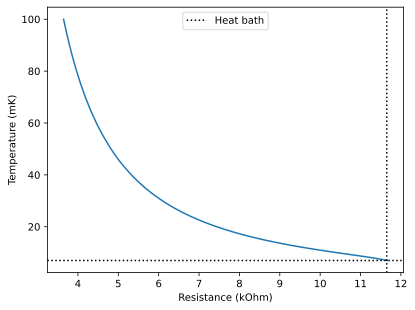

In [3]:
plt.plot(1e-3*bluefors_tab_R, 1e3*bluefors_tab_K)
plt.xlabel('Resistance (kOhm)')
plt.ylabel('Temperature (mK)')
plt.axvline(11.65, label='Heat bath', linestyle='dotted', color='black')
plt.axhline(7., linestyle='dotted', color='black')
#plt.ylim(5,20)
#plt.xlim(5,20)
plt.legend()
plt.show()

In [4]:
utils_par = {
    'T_bath': 15,  # mK
    'Rs': 0.040,  # Ohm
    'L': 1.3e-6, # H 
    'record_length': 32768, 
            }
sample_frequency = {'summer': 50001, 'spring': 200001}
names = ['summer', 'spring']

t = {}
freq = {}
for name in names:
    t[name] = np.arange(0, utils_par['record_length'])/sample_frequency[name]
    freq[name] = np.fft.rfftfreq(utils_par['record_length'], d=1/sample_frequency[name])


# extract info from pulse shape

In [5]:
path = 'remo_tes_data/'

channels = {'summer': 1, 'spring': 1, }

sev = {'summer': np.loadtxt(path + 'run376_Channel_1_SEV_Particle.xy', skiprows=3), 
       'spring': np.loadtxt(path + 'run599_Channel_1_SEV_Particle.xy', skiprows=3),
      }


In [6]:
def pulse_template(t, t0, An, At, tau_n, tau_in, tau_t):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = (An * (np.exp(-(t[cond] - t0) / tau_n) - np.exp(-(t[cond] - t0) / tau_in)) + \
                   At * (np.exp(-(t[cond] - t0) / tau_t) - np.exp(-(t[cond] - t0) / tau_n)))
    return pulse

In [7]:
def single_pulse(t, t0, A, tau_rise, tau_decay):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = A * (np.exp(-(t[cond] - t0) / tau_decay) - np.exp(-(t[cond] - t0) / tau_rise))
    return pulse

In [8]:
x0 = np.array([-3.00000000e+00, -2.78575387e+00,  4.50000000e-01,  2.42000000e+00,
        4.43880749e+00,  6.00000000e+02])

pspars = {'summer': x0, }

In [9]:
pspars_fit = {}
pspars_std = {}
minis = {}

name = 'summer'
    
down = 16
x = sev['summer'][:,0]*1000
x = np.mean(x.reshape(-1, down), axis=-1)
y = sev['summer'][:,1]
y = np.mean(y.reshape(-1, down), axis=-1)
c = cost.LeastSquares(x=x, y=y, yerror=1e-3*np.ones(x.shape[0]), model=pulse_template)

minis['summer'] = Minuit(c, *pspars['summer'])

In [10]:
minis['summer'].interactive()

In [11]:
pspars_fit['summer'] = np.array(minis['summer'].values)

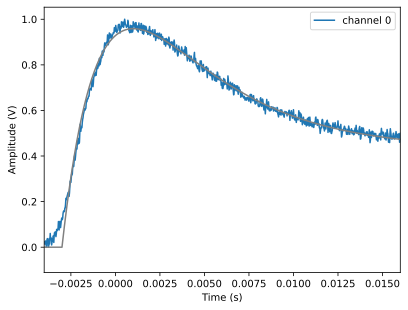

In [12]:
t0 = [0., 0., 0.]

c = 0

plt.plot(sev['summer'][:,0] - t0[c], sev['summer'][:,1], label=f'channel {c}')
plt.plot(sev['summer'][:,0] - t0[c], pulse_template(sev['summer'][:,0]*1000, *pspars_fit['summer']), color='grey')

plt.xlim(-0.004,0.016)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

In [13]:
pspars['spring'] = np.array([-2.80000000e-01, -4.15604972e+00,  9.50000000e-01,  2.44000000e+00, 2.80000000e+00,  1.20000000e+03])


In [14]:
name = 'spring'
    
x = sev['spring'][:,0]*1000
x = np.mean(x.reshape(-1, down), axis=-1)
y = sev['spring'][:,1]
y = np.mean(y.reshape(-1, down), axis=-1)
c = cost.LeastSquares(x=x, y=y, yerror=1e-3*np.ones(x.shape[0]), model=pulse_template)

minis['spring'] = Minuit(c, *pspars[name])

In [15]:
minis['spring'].interactive()

In [16]:
pspars_fit['spring'] = np.array(minis['spring'].values)

In [17]:
pspars_fit['spring']

array([-2.80000000e-01, -4.15604972e+00,  9.50000000e-01,  2.44000000e+00,
        2.80000000e+00,  1.20000000e+03])

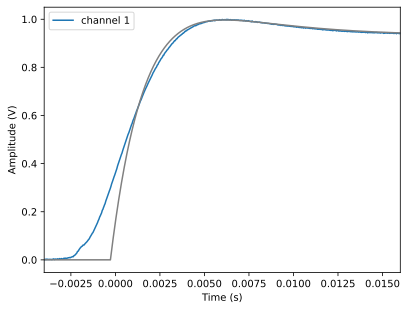

In [18]:
t0 = [-0.0055, 0., 0.]

# for c,name in enumerate(names):

name = 'spring'
c = 1

plt.plot(sev['spring'][:,0] - t0[c], sev['spring'][:,1], label=f'channel {c}')
plt.plot(sev['spring'][:,0] - t0[c], pulse_template(sev['spring'][:,0]*1000, *pspars_fit['spring']), color='grey')

plt.xlim(-0.004,0.016)
#plt.ylim(0.88,1.02)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

In [19]:
pspars_fit['spring'] = np.array(minis['spring'].values)

In [20]:
Afast = {}
Aslow = {}
tau_rise = {}
tau_fast = {}
tau_slow = {}

for name in names:
    Afast[name] = pspars_fit[name][1]
    Aslow[name] = pspars_fit[name][2]
    tau_rise[name] = pspars_fit[name][3]*1e-3  # s
    tau_fast[name] = pspars_fit[name][4]*1e-3  # s
    tau_slow[name] = pspars_fit[name][5]*1e-3  # s

## testpulses

In [21]:
sev_tp = {'summer': np.loadtxt(path + 'run376_Channel_1_SEV_TP.xy', skiprows=3), 
       'spring': np.loadtxt(path + 'run599_Channel_1_SEV_TP.xy', skiprows=3),
      }

In [22]:
x0 = np.array([-1.19, -1.51,  0.13,  0.5,
        3.,  6.00000000e+02])

pspars_tp = {'summer': x0, }

In [23]:
pspars_fit_tp = {}
pspars_std_tp = {}
minis_tp = {}

name = 'summer'
    
down = 16
x = sev_tp['summer'][:,0]*1000
x = np.mean(x.reshape(-1, down), axis=-1)
y = sev_tp['summer'][:,1]
y = np.mean(y.reshape(-1, down), axis=-1)
c = cost.LeastSquares(x=x, y=y, yerror=1e-3*np.ones(x.shape[0]), model=pulse_template)

minis_tp['summer'] = Minuit(c, *pspars_tp['summer'])

In [24]:
minis_tp['summer'].interactive()

In [25]:
pspars_fit_tp['summer'] = np.array(minis_tp['summer'].values)

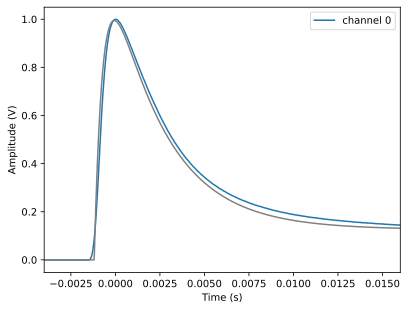

In [26]:
t0 = [0., 0., 0.]

c = 0

plt.plot(sev_tp['summer'][:,0] - t0[c], sev_tp['summer'][:,1], label=f'channel {c}')
plt.plot(sev_tp['summer'][:,0] - t0[c], pulse_template(sev_tp['summer'][:,0]*1000, *pspars_fit_tp['summer']), color='grey')

plt.xlim(-0.004,0.016)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

In [27]:
pspars_tp['spring'] = np.array([-1.39, -4.15604972e+00,  0.04,  2.06, 3.89,  1.20000000e+03])


In [28]:
name = 'spring'
    
x = sev_tp['spring'][:,0]*1000
x = np.mean(x.reshape(-1, down), axis=-1)
y = sev_tp['spring'][:,1]
y = np.mean(y.reshape(-1, down), axis=-1)
c = cost.LeastSquares(x=x, y=y, yerror=1e-3*np.ones(x.shape[0]), model=pulse_template)

minis_tp['spring'] = Minuit(c, *pspars_tp[name])

In [29]:
minis_tp['spring'].interactive()

In [30]:
pspars_fit_tp['spring'] = np.array(minis_tp['spring'].values)

In [31]:
pspars_fit_tp['spring']

array([-1.39000000e+00, -4.15604972e+00,  4.00000000e-02,  2.06000000e+00,
        3.89000000e+00,  1.20000000e+03])

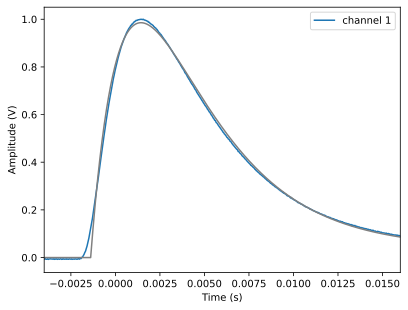

In [32]:
t0 = [-0.0055, 0., 0.]

# for c,name in enumerate(names):

name = 'spring'
c = 1

plt.plot(sev_tp['spring'][:,0] - t0[c], sev_tp['spring'][:,1], label=f'channel {c}')
plt.plot(sev_tp['spring'][:,0] - t0[c], pulse_template(sev_tp['spring'][:,0]*1000, *pspars_fit_tp['spring']), color='grey')

plt.xlim(-0.004,0.016)
#plt.ylim(0.88,1.02)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

In [33]:
pspars_fit_tp['spring'] = np.array(minis_tp['spring'].values)

In [34]:
Afast_tp = {}
Aslow_tp = {}
tau_rise_tp = {}
tau_fast_tp = {}
tau_slow_tp = {}

for name in names:
    Afast_tp[name] = pspars_fit_tp[name][1]
    Aslow_tp[name] = pspars_fit_tp[name][2]
    tau_rise_tp[name] = pspars_fit_tp[name][3]*1e-3  # s
    tau_fast_tp[name] = pspars_fit_tp[name][4]*1e-3  # s
    tau_slow_tp[name] = pspars_fit_tp[name][5]*1e-3  # s

# extract transition curves

In [210]:
transition_curves = {'summer': np.loadtxt(path + 'run579_Raj_transition_cooldown.xy', skiprows=4), 
                     'spring': np.loadtxt(path + 'run599_NaI_transition_cooldown.xy', skiprows=4), 
                     'summer_wu': np.loadtxt(path + 'run579_Raj_transition_warmup.xy', skiprows=4), 
                     'spring_wu': np.loadtxt(path + 'run599_NaI_transition_warmup.xy', skiprows=4), 
                    }

In [36]:
tes_rt0 = {'summer': 0.070, 'spring': 0.290,}  # Ohm
bias = {'summer': 1., 'spring': 1., }  # muA

In [105]:
v_to_muA = {'summer': .15, 'spring': 0.06}  # this should be for run599 0.05945945945945945 (wrong in SQUID settings)

In [106]:
v_sets = {'summer': .9, 'spring': 2.,} 
Vph_iron = {'summer': 0.0059, 'spring': 0.015,} 

In [107]:
Is_max = {}
Rf_max = {}
Is_op = {}
Rs_max = {}
R_op = {}

for name in names:
    Is_max[name] = bias[name] * tes_rt0[name] / (tes_rt0[name] + utils_par['Rs'])
    Rf_max[name] = Is_max[name] * utils_par['Rs'] / (bias[name] - Is_max[name])
    Is_op[name] = Is_max[name] - v_to_muA[name] * v_sets[name]
    R_op[name] = Is_op[name] * utils_par['Rs'] / (bias[name] - Is_op[name])

In [108]:
V_op = {}

for name in names:

    V_op[name] = bias[name] / v_to_muA[name] / (utils_par['Rs'] / tes_rt0[name] + 1) - v_sets[name]
    R_op[name] = utils_par['Rs'] / (bias[name] / v_to_muA[name] / V_op[name] - 1)

In [109]:
R_op

{'summer': 0.040218778486782146, 'spring': 0.12582914572864323}

In [110]:
dRdT_op = {'summer': 0.02 / 0.05, 
           'spring': .1 / 1,
          }  # Ohm / mK

In [111]:
T_op = {'summer': 27.95, 'spring': 32.6}  # mK

In [112]:
dRdT_op

{'summer': 0.39999999999999997, 'spring': 0.1}

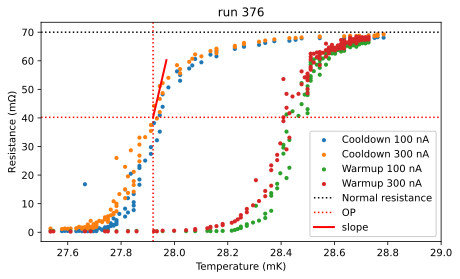

In [113]:
fig = plt.figure(dpi=300, figsize=(6.5,4))
plt.scatter(1000*res_to_temp(1e3*transition_curves['summer'][:,0]), transition_curves['summer'][:,1], 
            label='Cooldown 100 nA', rasterized=True, s=10)
plt.scatter(1000*res_to_temp(1e3*transition_curves['summer'][:,0]), transition_curves['summer'][:,2], 
            label='Cooldown 300 nA', rasterized=True, s=10)
plt.scatter(1000*res_to_temp(1e3*transition_curves['summer_wu'][:,0]), transition_curves['summer_wu'][:,1], 
            label='Warmup 100 nA', rasterized=True, s=10)
plt.scatter(1000*res_to_temp(1e3*transition_curves['summer_wu'][:,0]), transition_curves['summer_wu'][:,2], 
            label='Warmup 300 nA', rasterized=True, s=10)
# plt.axvline(1000*T_op['summer']*1e-3, color='black', linestyle='dashed', label='Critical temperature')
plt.axhline(70, color='black', linestyle='dotted', label='Normal resistance')
plt.axhline(R_op['summer']*1e3, color='red', linestyle='dotted', label='OP')
plt.axvline(1000*0.02792, color='red', linestyle='dotted')
plt.plot([1000*0.02792, 1000*(0.02792 + 0.00005)], [R_op['summer']*1e3, R_op['summer']*1e3 + 1e6*0.00005*dRdT_op['summer']], color='red', linestyle='solid', 
         label='slope', linewidth=2.)
plt.title('run 376')
plt.xlim(1000*0.0275, 1000*0.029)
plt.legend(loc='lower right', framealpha=1.)
plt.xlabel('Temperature (mK)')
plt.ylabel(r'Resistance (m$\Omega$)')
plt.tight_layout()
plt.savefig('plots_paper/run376_transition_curve.png')
plt.show()

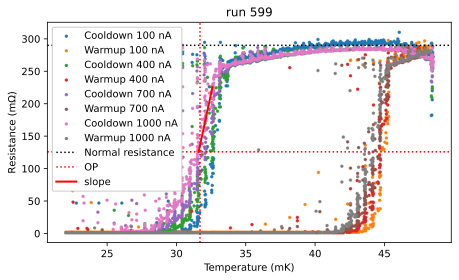

In [114]:
fig = plt.figure(dpi=150, figsize=(6.5,4))
for i, amp in zip([1,2,3,4], [100, 400, 700, 1000]):
    plt.scatter(1000*res_to_temp(1e3*transition_curves['spring'][:,0]), transition_curves['spring'][:,i], 
                label='Cooldown {} nA'.format(amp), rasterized=True, s=5)
    plt.scatter(1000*res_to_temp(1e3*transition_curves['spring_wu'][:,0]), transition_curves['spring_wu'][:,i], 
                label='Warmup {} nA'.format(amp), rasterized=True, s=5)
# plt.axvline(T_op['spring']*1e-3, color='black', linestyle='dashed', label='Critical temperature')
plt.axhline(290, color='black', linestyle='dotted', label='Normal resistance')
plt.axhline(R_op['spring']*1e3, color='red', linestyle='dotted', label='OP')
plt.axvline(1000*0.0317, color='red', linestyle='dotted')
plt.plot([1000*T_op['spring']*1e-3 - 1, 1000*T_op['spring']*1e-3 + 1000*0.001 - 1], 
         [R_op['spring']*1e3, R_op['spring']*1e3 + 0.001*1e6*dRdT_op['spring']], color='red', 
         linestyle='solid', label='slope', linewidth=2.)
plt.title('run 599')
plt.legend(framealpha=1.)
plt.xlabel('Temperature (mK)')
plt.ylabel(r'Resistance (m$\Omega$)')
plt.tight_layout()
plt.savefig('plots_paper/run599_transition_curve.png')
plt.show()

In [115]:
R_iron = {}  # resistance increase for iron events
Tph_iron = {}

for name in names:
    
    R_iron[name] = utils_par['Rs'] / (bias[name] / v_to_muA[name] / V_op[name] - 1) + v_to_muA[name] * utils_par['Rs'] * bias[name] / (bias[name] - v_to_muA[name] * V_op[name]) ** 2 * Vph_iron[name] 
    Tph_iron[name] = (R_iron[name] - R_op[name]) / dRdT_op[name]

In [116]:
R_iron

{'summer': 0.040361154021616934, 'spring': 0.1264478801040378}

In [117]:
Tph_iron

{'summer': 0.00035593883708696933, 'spring': 0.0061873437539455844}

# heat capacities

In [118]:
kB = 1.380649e-17  # mm ^ 2 * g / s^2 / mK     # nJ / mK
na = 6.02214076e23  # number of items per mole
h_const = 6.62607015e-34  # kg * m^2 / s
e_charge = 1.60217663e-19  # coulombs

In [119]:
density = {'W': 0.01935, 'Au': 0.01932, 'Al': 0.002702, 'CaWO4': 0.00606, 'Si': 0.00233, 'Al2O3': 0.00398, 'LiAlO2': 0.002615, 
           'Cu': 0.0089, 'NaI': 0.00367}  # g/mm^3
molar_mass = {'W': 183.84, 'Au': 196.96655, 'Al': 26.981538, 'CaWO4': 287.9156, 'Si': 28.0855, 'Al2O3': 101.961276, 'LiAlO2': 65.92, 
              'Cu': 63.546, 'NaI': 149.89}  # g/mole

energy_gap = {'CaWO4': 5.2e-3, 'Si': 1.12e-3, 'Al203': 8.3e-3, 'LiAlO2': 4.59, 'Cu': 0.0, }  # keV
sommerfeld_constant = {'W': 1.01e3, 'Au': 0.729e3, 'Al': 1.356e3, 'Cu': 0.7e3, }  # pJ / mol / mK^2 ; gold value is from Florians book
fermi_temp = {'W': 27_000_000, 'Au': 63_900_000, 'Al': 134_900_000, 'Cu': 8_160_000, }  # mK
electron_phonon_coupling = {'W': 2.1e-4}  # pW / mK^6 / mm^3 - multiply with T^5 (mK) and volume (mm^3)
thermal_conductivity = {'Au': 17.1e3}  # pW / mK^2 / mm - multiply with temperature (mK) and cross section (mm^2), divide by length (mm) 


In [120]:
# below are constants of the materials

debye_frequency = {'CaWO4': 4.7, 'Si': 13.5, 'Al2O3': 21.7,  # from pantic thesis , THz
                   'LiAlO2': 8.943, 'Cu': 7.22, }  # calc above
                # mK  # debye_temp * h_const / kB
debye_temp = {'W': 383_000, 'Au': 162_000, 'Al': 428_000, 'CaWO4': 228_000, 'Si': 648_000, 'Al2O3': 1_041_000,  # from pantic thesis 
              'LiAlO2': 429_202, 'Cu': 346_328, 'NaI': 165_000}  # mK 


In [121]:
abs_material = {'summer': 'NaI', 'spring': 'NaI', }
abs_volume = {'summer': 1000, 'spring': 1000, }  # mm^3
abs_surface = {'summer': 600, 'spring': 600, }  # mm^2

tes_thickness = {'summer': 0.00008, 'spring': 0.00008*3, }  # mm
tes_surface = {'summer': .04, 'spring': .04, }  # mm^2 

au_thickness = {'summer': 0.001, 'spring': 0.008, }  # mm
au_surface = {'summer': 2., 'spring': 2., }  # mm^2 


In [122]:
Cph_mm3 = {}  # pJ / mK / mm^3
Ce_mm3 = {}  # pJ / mK / mm^3
Cph = {}  # pJ / mK
Ce = {}  # pJ / mK
Ce_normal = {}  # pJ / mK
Cph_tes = {}  # pJ / mK  # we ignore this in the end!
Cau = {}

for name in names:
    mat = abs_material[name]
    n_mol_mm3 = density[mat] / molar_mass[mat] 
    Cph_mm3[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol_mm3 * 1e3
    
    n_mol = abs_volume[name] * density[mat] / molar_mass[mat] 
    Cph[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3
    
    n_mol_mm3 = density['W'] / molar_mass['W']
    Ce_mm3[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol_mm3 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W']
    Ce_normal[name] = sommerfeld_constant['W'] * T_op[name] * n_mol 
    Ce[name] = Ce_normal[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name])
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W'] 
    Cph_tes[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp['W']) ** 3 * n_mol * 1e3

    n_mol = au_surface[name] * au_thickness[name] * density['Au'] / molar_mass['Au']
    Cau[name] = sommerfeld_constant['Au'] * T_op[name] * n_mol
    print(n_mol)
    

1.9617544197225367e-07
1.5694035357780294e-06


In [123]:
Cph  # pJ / mK

{'summer': 0.23132998315903994, 'spring': 0.3670618843428502}

In [124]:
Ce  # pJ / mK

{'summer': 1.5292725583167888e-05, 'spring': 6.0202907631350236e-05}

In [125]:
Cph_tes  # pJ / mK

{'summer': 2.544397549536968e-10, 'spring': 1.2111936545747414e-09}

In [126]:
Cau  # pJ / mK

{'summer': 0.003997182526677753, 'spring': 0.037297502789179184}

# pars for cryosig

In [127]:
open_loop_out = {'summer': 1.88, 'spring': 1.485, }  # V

In [128]:
thermal_link = {'summer': 0.457, 'spring': 0.3, }  # pW / mK 

In [129]:
absorber_bath = {'summer': 0.1456, 'spring': 0.04, }  # pW / mK 

In [130]:
eph_coupling = {'summer': .51, 'spring': 17.5, }  # pW / mK  

In [131]:
epsilon = {'summer': 0.04, 'spring': 0.2, }

In [132]:
heater_resistance = {'summer': 10., 'spring': 10., }

In [133]:
autes_coupling = {'summer': 1, 'spring': 1., }

In [134]:
pulser_amplitude = {'summer': 0.1, 'spring': 0.1, }

In [135]:
heater_current = {'summer': 2., 'spring': 2., }  # muA

In [136]:
tpa_height = {'summer': 0.23, 'spring': 0.7, }

In [137]:
nps = {'summer': np.loadtxt(path + 'run376_Channel_1_NPS.xy', skiprows=3), 
       'spring': np.loadtxt(path + 'run599_Channel_1_NPS.xy', skiprows=3), }

for name in names:
    
    norm_factor = 2 / sample_frequency[name] / utils_par['record_length'] / 0.875
    
    nps[name][:,1] *= norm_factor # V^2 / Hz
    nps[name][:,1] *= v_to_muA[name] ** 2  # muA^2 / Hz

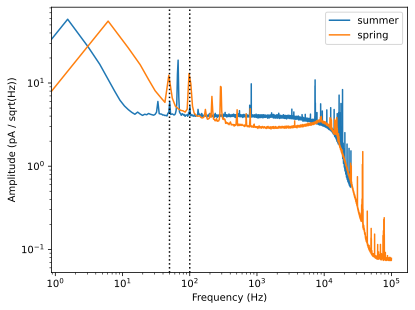

In [138]:
for name in names:
    plt.loglog(nps[name][:,0], 1e6*np.sqrt(nps[name][:,1]), label=name)
plt.axvline(50, color='black', linestyle='dotted')
plt.axvline(100, color='black', linestyle='dotted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (pA / sqrt(Hz))')
plt.legend()
plt.show()

In [139]:
i_sq = {'summer': 1.2, 'spring': 1.2, }  # 

In [142]:
tes_fluct = {'summer': 9e-3, 'spring': 5e-3, }

In [180]:
excess_johnson = {'summer': np.array([2.]), 'spring': np.array([3.]), }
# 2, 3

In [181]:
flicker_slope = {'summer': 2.5, 'spring': .1, }

In [182]:
lowpass = {'summer': 2e4, 'spring': 1e4, }

In [183]:
trigger_onset = {'summer': .16384, 'spring': .04096}

In [184]:
Vph_tp = {'summer': .23, 'spring': .35}  # attention, for spring run this is the 0.6 TPA amplitude!

In [185]:
emi = {'summer': [0.,0.,0.], 'spring': [0.,0.,0.], }

In [186]:
R_op_target = {'summer': tes_rt0['summer']*0.6, 'spring': tes_rt0['spring']*0.6, }

In [187]:
pars = {}

for name in names:

    pars[name] = {
        'C': np.array([Ce[name] + Cau[name], Cph[name]]),  # pJ / mK, is defined later bec mutable
        'Gb': np.array([thermal_link[name], absorber_bath[name]]),  # pW / mK
        'G': np.array([[0., eph_coupling[name]], 
                       [eph_coupling[name], 0.], ]),  # heat cond between components, pW / mK
        'lamb': np.array([tau_rise[name], tau_rise[name]]),  # thermalization time (s)
        'lamb_tp': np.array([0.003]),
        'eps': np.array([[epsilon[name], 1 - epsilon[name]], 
                         [epsilon[name], 1 - epsilon[name]], ]),  # share thermalization in components
        'delta': np.array([[1., 0.], ]),  
        'delta_h': np.array([[1., 0.,], ]),  
        'Rs': np.array([utils_par['Rs']]),  # Ohm
        'Rh': np.array([heater_resistance[name]]),  # Ohm
        'L': np.array([utils_par['L']]),  # H
        'Rt0': np.array([tes_rt0[name]]),  # Ohm
        'k': np.array([0.5*dRdT_op[name]/tes_rt0[name]]) if name == 'summer' else np.array([9*dRdT_op[name]/tes_rt0[name]]),  # 1/mK  
        'Tc': np.array([T_op[name] - 0.1 if name == 'summer' else T_op[name]]),  # mK  
        'Ib': np.array([bias[name]]),  # muA
        'dac': np.array([open_loop_out[name]]),  # V
        'pulser_scale': np.array([pulser_amplitude[name]]),  # scale factor
        'heater_current': np.array([heater_current[name]]),  # TODO should be different
        'eta': np.array([1/v_to_muA[name]]),
        'tes_flag': np.array([True, False], dtype=bool),  # which component is a tes
        'heater_flag': np.array([True, False], dtype=bool),  # which component has a heater
        'i_sq': np.array([i_sq[name]]),  # squid noise, A / sqrt(Hz) 
        'tes_fluct': np.array([tes_fluct[name]]),  # ??  # TODO fix units
        'flicker_slope': np.array([flicker_slope[name]]),
        'emi': np.array([emi[name]]),  # ??  # TODO fix units and only the peaks
        'tau_cap': np.array([1.]),
        'Ib_range': (0., 17.86),
        'excess_johnson': excess_johnson[name],
        'tau_eff': tau_fast[name],
        'tau_t': tau_slow[name],
        'nps': nps[name],
        'sev': sev[name],
        'sev_tp': sev_tp[name],
        'tpa_height' : tpa_height[name],
        'dRdT_op': dRdT_op[name],   
        'transition_curve': transition_curves[name],
        'Afast': Afast[name],
        'Aslow': Aslow[name],
        'Vph_iron': Vph_iron[name],
        'R_iron': R_iron[name],
        'V_op': V_op[name],
        'Tph_iron': Tph_iron[name],
        'lowpass': lowpass[name],
        'record_length': utils_par['record_length'],
        'sample_frequency': sample_frequency[name],
        'R_op_target': R_op_target[name],
        't0': trigger_onset[name],
        'tp_interval': 10,
        'adjust_heatcap': False,
    }

In [188]:
pars

{'summer': {'C': array([0.00401248, 0.23132998]),
  'Gb': array([0.457 , 0.1456]),
  'G': array([[0.  , 0.51],
         [0.51, 0.  ]]),
  'lamb': array([0.00242, 0.00242]),
  'lamb_tp': array([0.003]),
  'eps': array([[0.04, 0.96],
         [0.04, 0.96]]),
  'delta': array([[1., 0.]]),
  'delta_h': array([[1., 0.]]),
  'Rs': array([0.04]),
  'Rh': array([10.]),
  'L': array([1.3e-06]),
  'Rt0': array([0.07]),
  'k': array([2.85714286]),
  'Tc': array([27.85]),
  'Ib': array([1.]),
  'dac': array([1.88]),
  'pulser_scale': array([0.1]),
  'heater_current': array([2.]),
  'eta': array([6.66666667]),
  'tes_flag': array([ True, False]),
  'heater_flag': array([ True, False]),
  'i_sq': array([1.2]),
  'tes_fluct': array([0.009]),
  'flicker_slope': array([2.5]),
  'emi': array([[0., 0., 0.]]),
  'tau_cap': array([1.]),
  'Ib_range': (0.0, 17.86),
  'excess_johnson': array([2.]),
  'tau_eff': 0.00443880749,
  'tau_t': 0.6,
  'nps': array([[0.00000000e+00, 0.00000000e+00],
         [1.52587

In [189]:
pars_det = deepcopy(pars)

# find couplings and noise contributions from sim for run 376

In [190]:
import cryoenv.cryosig as cs
import numpy as np

In [191]:
name = names[0]

In [192]:
det = cs.DetectorModel(**pars_det[name])

In [193]:
det.set_control(dac=[1.88], Ib=[1.], norm=False)  # 1.865

det.wait(20)

det.trigger(er=np.array([0., 6.]), tpa=np.array([0.0])) 

print(det.ph)
print(det.T[-1])

T0 is [28.20406528 25.27161882] mK.
Calculated in 0.15515804290771484 s.
Generated noise in 0.011842966079711914 s.
[0.01418237]
[28.20501898 25.27341671]


In [194]:
t0_ = {'summer': 0.003, 'spring': 0.001, }

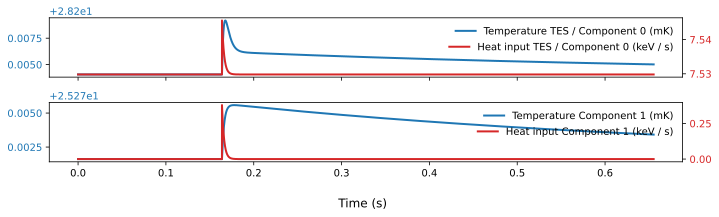

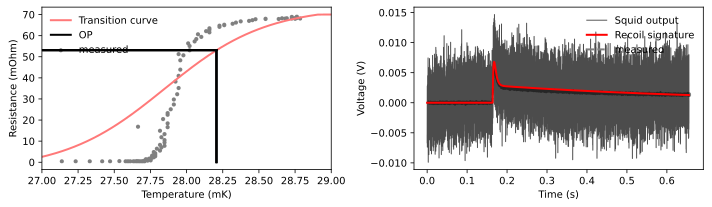

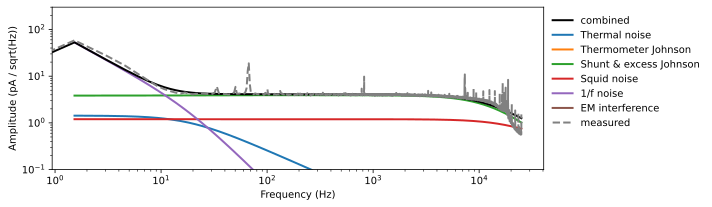

In [195]:
det.plot_temperatures(save_path=None, dpi=300)  # xlim=(0.16, 0.2)

# xlim_temp=(27.3, 28.3), xlim_time=(0.15, 0.25),  
# xlim_temp=(28., 36.), xlim_time=(0.02, 0.06), 
fig, axes = det.plot_tes((27., 29.), save_path=None, show=False, dpi=300)  # xlim_time=(0.15, 0.25),  
axes[0].scatter(res_to_temp(pars[name]['transition_curve'][:150,0]*1e3)*1e3, pars[name]['transition_curve'][:150,1], 
                rasterized=True, color='grey', s=10, label='measured')
axes[1].plot(det.kwargs['sev'][:,0] + t0_[name] + trigger_onset[name], det.kwargs['sev'][:,1]*Vph_iron[name], linestyle='dashed', color='grey', linewidth=2, label='measured')
# axes[1].plot(sev_tp[name][:,0] + 0. + 0.16384, sev_tp[name][:,1]*Vph_tp[name], linestyle='dashed', color='grey', linewidth=2, label='measured')
axes[0].set_title('')
axes[1].set_title('')
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig('plots_paper/run376_tes_sim.png')
plt.show()

for i in range(det.nmbr_tes):
    det.plot_nps(tes_channel=i, only_sum=False, save_path=None, show=False, dpi=300)  # 'plots_paper/nps_tes_{}.png'.format(i)
    plt.loglog(det.kwargs['nps'][:,0], np.sqrt(det.kwargs['nps'][:,1])*1e6, color='grey', linestyle='dashed', linewidth=2, label='measured', zorder=100)
    plt.legend(frameon=False, bbox_to_anchor=(1., 1.))
    plt.ylim(1e-1, 3e2)
    plt.title('')
    plt.tight_layout()
    plt.savefig('plots_paper/run376_nps_sim.png')
    plt.show()

In [196]:
# det.tpa_queue=np.array([0.1, 1, 5, 10, ])
# det.dac_ramping_speed=np.array([1e-4])
# det.sweep_dac(1.9,1.7)

In [197]:
# det.plot_buffer()

In [198]:
det.Rt[0](det.T[0,0])

0.05296398655753224

# find couplings and noise contributions from sim for run 599

In [199]:
import cryoenv.cryosig as cs
import numpy as np

In [200]:
name = names[1]

In [201]:
det = cs.DetectorModel(**pars_det[name])

In [202]:
# rranges = (slice(0, 1., 5e-2),
#            slice(0, 2., 5e-2),
#            slice(0, 1., 5e-2),
#            )

# resbrute = det.solve_time_constants([det.kwargs['tau_eff'], det.kwargs['tau_t']], rranges, print_iv=10000)

In [203]:
# resbrute[0]

In [204]:
det.set_control(dac=[1.485], Ib=[1.], norm=False)  

det.wait(20)

det.trigger(er=np.array([0., 6.]), tpa=np.array([0.0])) 

print(det.ph)
print(det.T[-1])

T0 is [32.49739271 32.45748986] mK.
Calculated in 0.5672688484191895 s.
Generated noise in 0.010626792907714844 s.
[0.04575095]
[32.49950496 32.45963541]


In [205]:
t0_ = {'summer': 0.003, 'spring': 0.001, }

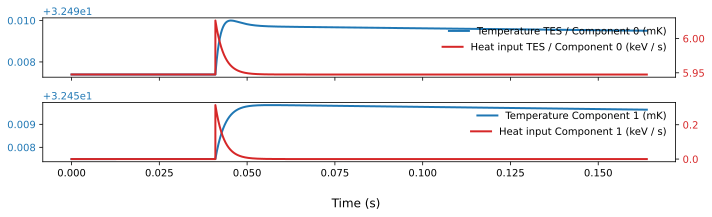

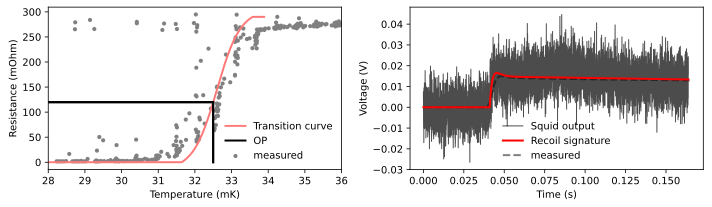

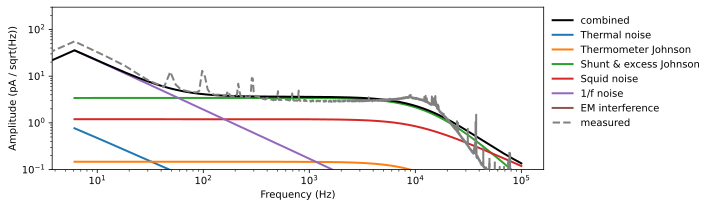

In [206]:
det.plot_temperatures(save_path=None, dpi=300)  # xlim=(0.16, 0.2)

# xlim_temp=(27.3, 28.3), xlim_time=(0.15, 0.25),  
# xlim_temp=(28., 36.), xlim_time=(0.02, 0.06), 
fig, axes = det.plot_tes((28., 36.), save_path=None, show=False, dpi=300)  # xlim_time=(0.15, 0.25),  
# axes[0].scatter(res_to_temp(pars[name]['transition_curve'][:150,0]*1e3)*1e3, pars[name]['transition_curve'][:150,1], 
#                 rasterized=True, color='grey', s=10, label='measured')
axes[0].scatter(res_to_temp(pars[name]['transition_curve'][600:-300,0]*1e3)*1e3, pars[name]['transition_curve'][600:-300,1], 
                rasterized=True, color='grey', s=10, label='measured')
axes[1].plot(det.kwargs['sev'][:,0] + t0_[name] + trigger_onset[name], det.kwargs['sev'][:,1]*Vph_iron[name], linestyle='dashed', color='grey', linewidth=2, label='measured')
# axes[1].plot(sev_tp[name][:,0] + 0. + 0.16384, sev_tp[name][:,1]*Vph_tp[name], linestyle='dashed', color='grey', linewidth=2, label='measured')
axes[0].set_title('')
axes[1].set_title('')
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig('plots_paper/run599_tes_sim.png')
plt.show()

for i in range(det.nmbr_tes):
    det.plot_nps(tes_channel=i, only_sum=False, save_path=None, show=False, dpi=300)  # 'plots_paper/nps_tes_{}.png'.format(i)
    plt.loglog(det.kwargs['nps'][:,0], np.sqrt(det.kwargs['nps'][:,1])*1e6, color='grey', linestyle='dashed', linewidth=2, label='measured', zorder=100)
    plt.legend(frameon=False, bbox_to_anchor=(1., 1.))
    plt.ylim(1e-1, 3e2)
    plt.title('')
    plt.tight_layout()
    plt.savefig('plots_paper/run599_nps_sim.png')
    plt.show()

In [207]:
# det.tpa_queue=np.array([0.1, 1, 5, 10, ])
# det.dac_ramping_speed=np.array([1e-4])
# det.sweep_dac(1.6,1.4)

In [208]:
# det.plot_buffer()

In [209]:
det.Rt[0](det.T[0,0])

0.119436236861257